In [1]:
import tensorflow as tf


In [2]:
# Creates a graph.
with tf.device('/cpu:0'):
  a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
  b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
  c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print sess.run(c)

[[ 22.  28.]
 [ 49.  64.]]


In [1]:
# Incorporate point-correlation
def correlation_fun(x,input_dim,Rad):
    point_corr=0
    for i in range(input_dim):
        for j in range(input_dim):
            point_corr_temp1=tf.multiply(x[0][i,j],x[0][i,tf.mod(j+Rad,input_dim)])
            point_corr=tf.add(point_corr_temp1,point_corr)
    
    for i in range(input_dim):
        for j in range(input_dim):           
            point_corr_temp2=tf.multiply(x[0][i,j],x[0][tf.mod(i+Rad,input_dim),j])
            point_corr=tf.add(point_corr_temp2,point_corr)
    return (point_corr+2*input_dim**2)/4./1

In [2]:
def correlation_fun_test(x,input_dim,Rad):
    point_corr=0
#     if Rad <=50:
    for i in range(input_dim):
        for j in range(input_dim):
            point_corr_temp1=(x[i,j]*x[i,np.mod(j+Rad,input_dim)])
            point_corr=point_corr_temp1+point_corr

    for i in range(input_dim):
        for j in range(input_dim):
            point_corr_temp2=x[i,j]*x[np.mod(i+Rad,input_dim),j]
            point_corr=(point_corr_temp2+point_corr)
#     print(point_corr)
    return (point_corr+2*input_dim**2)/4.

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import scipy.io as sio
# from torch.autograd import Variable
from tensorflow.examples.tutorials.mnist import input_data



# mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)
images = np.array(sio.loadmat('WB_test64_GAN_sm2.mat')['WB_sm'],dtype='float32')
images[images==0]=-1

mb_size = 1
z_dim = 8
X_dim = images.shape[1]
width = 32
hight = 32
h_dim = 8*8
input_dim = 32
Rad = input_dim/2

conv1_features=64
conv2_features=32
conv3_features=1
c = 0

num_channels_1=1
num_channels_2=64
num_channels_3=32
lr = 1e-3

VF = []
for i in range(0,100,10):
    VF = np.append(VF, correlation_fun_test(x=images[i].reshape(32,32),input_dim=32,Rad=16))
print('VF=',VF)
y_target=np.mean(VF)

VF2 = []
for i in range(0,100,10):
    VF2 = np.append(VF2, correlation_fun_test(x=images[i].reshape(32,32),input_dim=32,Rad=1))
print('VF2=',VF2)
y_target2=np.mean(VF2)

VF3 = []
for i in range(0,100,10):
    VF3 = np.append(VF3, correlation_fun_test(x=images[i].reshape(32,32),input_dim=32,Rad=3))
print('VF3=',VF3)
y_target3=np.mean(VF3)

VF4 = []
for i in range(0,100,10):
    VF4 = np.append(VF4, correlation_fun_test(x=images[i].reshape(32,32),input_dim=32,Rad=6))
print('VF4=',VF4)
y_target4=np.mean(VF4)

VF5 = []
for i in range(0,100,10):
    VF5 = np.append(VF5, correlation_fun_test(x=images[i].reshape(32,32),input_dim=32,Rad=2))
print('VF5=',VF5)
y_target5=np.mean(VF5)

# VF6 = []
# for i in range(0,100,10):
#     VF6 = np.append(VF6, correlation_fun_test(x=images[i].reshape(32,32),input_dim=32,Rad=4))
# print('VF6=',VF6)
# y_target6=np.mean(VF6)


def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(32, 32), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

def Q(X):
#     conv1 = tf.nn.conv2d(X, conv1_weight, strides=[1, 1, 1, 1], padding='SAME')
#     h1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
#     h1 = tf.reshape(h1,[mb_size,X_dim])
    
    h = tf.nn.relu(tf.matmul(tf.reshape(X,[mb_size,X_dim]), Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar

def sample_z(mu, log_var):
    eps = tf.random_normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


def P(zz):
    h1 = tf.nn.relu(tf.matmul(zz, P_W1) + P_b1)
    h2 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h1,[mb_size, width/4, hight/4, 1]), 
                                                  deconv1_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/2, hight/2, conv1_features]),deconv1_bias))
#     h2 = build_unpool(h2_conv, [1, 2, 2, 1])
    
    h3 = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(tf.reshape(h2,[mb_size, width/2, hight/2, conv1_features]), 
                                                  deconv2_weight, strides=[1, 2, 2, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, conv2_features]),deconv2_bias))
    
    h4 = (tf.add(tf.nn.conv2d_transpose(tf.reshape(h3,[mb_size, width/1, hight/1, conv2_features]), 
                                                  deconv3_weight, strides=[1, 1, 1, 1], padding='SAME',
                                       output_shape=[mb_size, width/1, hight/1, conv3_features]),deconv3_bias))
    
    prob = tf.nn.tanh(h4)
    return prob


# =============================== Q(z|X) ======================================
with tf.device('/cpu:0'):
    # X = tf.placeholder(tf.float32, shape=[None, X_dim])
    zz = tf.placeholder(tf.float32, shape=[None, z_dim])
    z0 = tf.placeholder(tf.float32, shape=[None, z_dim])
    z1 = tf.placeholder(tf.float32, shape=[None, z_dim])
    z2 = tf.placeholder(tf.float32, shape=[None, z_dim])
    z3 = tf.placeholder(tf.float32, shape=[None, z_dim])
    z4 = tf.placeholder(tf.float32, shape=[None, z_dim])
    # z5 = tf.placeholder(tf.float32, shape=[None, z_dim])
    # z6 = tf.placeholder(tf.float32, shape=[None, z_dim])
    # z7 = tf.placeholder(tf.float32, shape=[None, z_dim])
    # z8 = tf.placeholder(tf.float32, shape=[None, z_dim])
    # z9 = tf.placeholder(tf.float32, shape=[None, z_dim])

    x_input_shape = (mb_size, width, hight, num_channels_1)
    X = tf.placeholder(tf.float32, shape=x_input_shape)
    y = tf.placeholder(tf.float32, None)
    y2= tf.placeholder(tf.float32, None)
    y3= tf.placeholder(tf.float32, None)
    y4= tf.placeholder(tf.float32, None)
    y5= tf.placeholder(tf.float32, None)
    # y6= tf.placeholder(tf.float32, None)
    # conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features],
    #                                                stddev=0.1, dtype=tf.float32))
    # conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

    Q_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
    Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

    Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
    Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

    Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
    Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))

    # =============================== P(X|z) ======================================

    P_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
    P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

    # P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
    # P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

    deconv1_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, num_channels_1],
                                                   stddev=0.1, dtype=tf.float32))
    deconv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))

    deconv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv2_features,num_channels_2],
                                                   stddev=0.1, dtype=tf.float32))
    deconv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

    deconv3_weight = tf.Variable(tf.truncated_normal([4, 4, conv3_features, num_channels_3],
                                                   stddev=0.1, dtype=tf.float32))
    deconv3_bias = tf.Variable(tf.zeros([conv3_features], dtype=tf.float32))



    # =============================== TRAINING ====================================

    z_mu, z_logvar = Q(X)
    z_sample = sample_z(z_mu, z_logvar)
    prob = P(z_sample)

    # Sampling from random z
    X_samples  = P(zz)
    X_samples0 = P(z0)
    X_samples1 = P(z1)
    X_samples2 = P(z2)
    X_samples3 = P(z3)
    X_samples4 = P(z4)
    # X_samples5 = P(z5)
    # X_samples6 = P(z6)
    # X_samples7 = P(z7)
    # X_samples8 = P(z8)
    # X_samples9 = P(z9)

    # point correlation loss
    PC_ori=correlation_fun(X, input_dim=input_dim, Rad=Rad)
    PC_rec=correlation_fun(prob, input_dim=input_dim, Rad=Rad)

    PC_ran_temp=tf.add_n([correlation_fun(X_samples0,input_dim=input_dim, Rad=Rad),
                     correlation_fun(X_samples1,input_dim=input_dim, Rad=Rad),
                     correlation_fun(X_samples2,input_dim=input_dim, Rad=Rad),
                     correlation_fun(X_samples3,input_dim=input_dim, Rad=Rad),
                     correlation_fun(X_samples4,input_dim=input_dim, Rad=Rad),
    #                  correlation_fun(X_samples5,input_dim=input_dim, Rad=Rad),
    #                  correlation_fun(X_samples6,input_dim=input_dim, Rad=Rad),
    #                  correlation_fun(X_samples7,input_dim=input_dim, Rad=Rad),
    #                  correlation_fun(X_samples8,input_dim=input_dim, Rad=Rad),
    #                  correlation_fun(X_samples9,input_dim=input_dim, Rad=Rad)
                         ])/5

    PC_ran_temp2=tf.add_n([correlation_fun(X_samples0,input_dim=input_dim, Rad=1),
                     correlation_fun(X_samples1,input_dim=input_dim, Rad=1),
                     correlation_fun(X_samples2,input_dim=input_dim, Rad=1),
                     correlation_fun(X_samples3,input_dim=input_dim, Rad=1),
                     correlation_fun(X_samples4,input_dim=input_dim, Rad=1),
    #                  correlation_fun(X_samples5,input_dim=input_dim, Rad=0),
    #                  correlation_fun(X_samples6,input_dim=input_dim, Rad=0),
    #                  correlation_fun(X_samples7,input_dim=input_dim, Rad=0),
    #                  correlation_fun(X_samples8,input_dim=input_dim, Rad=0),
    #                  correlation_fun(X_samples9,input_dim=input_dim, Rad=0)
                          ])/5

    PC_ran_temp3=tf.add_n([correlation_fun(X_samples0,input_dim=input_dim, Rad=3),
                     correlation_fun(X_samples1,input_dim=input_dim, Rad=3),
                     correlation_fun(X_samples2,input_dim=input_dim, Rad=3),
                     correlation_fun(X_samples3,input_dim=input_dim, Rad=3),
                     correlation_fun(X_samples4,input_dim=input_dim, Rad=3),
    #                  correlation_fun(X_samples5,input_dim=input_dim, Rad=3),
    #                  correlation_fun(X_samples6,input_dim=input_dim, Rad=3),
    #                  correlation_fun(X_samples7,input_dim=input_dim, Rad=3),
    #                  correlation_fun(X_samples8,input_dim=input_dim, Rad=3),
    #                  correlation_fun(X_samples9,input_dim=input_dim, Rad=3)
                          ])/5

    PC_ran_temp4=tf.add_n([correlation_fun(X_samples0,input_dim=input_dim, Rad=6),
                     correlation_fun(X_samples1,input_dim=input_dim, Rad=6),
                     correlation_fun(X_samples2,input_dim=input_dim, Rad=6),
                     correlation_fun(X_samples3,input_dim=input_dim, Rad=6),
                     correlation_fun(X_samples4,input_dim=input_dim, Rad=6),
    #                  correlation_fun(X_samples5,input_dim=input_dim, Rad=3),
    #                  correlation_fun(X_samples6,input_dim=input_dim, Rad=3),
    #                  correlation_fun(X_samples7,input_dim=input_dim, Rad=3),
    #                  correlation_fun(X_samples8,input_dim=input_dim, Rad=3),
    #                  correlation_fun(X_samples9,input_dim=input_dim, Rad=3)
                          ])/5

    PC_ran_temp5=tf.add_n([correlation_fun(X_samples0,input_dim=input_dim, Rad=2),
                     correlation_fun(X_samples1,input_dim=input_dim, Rad=2),
                     correlation_fun(X_samples2,input_dim=input_dim, Rad=2),
                     correlation_fun(X_samples3,input_dim=input_dim, Rad=2),
                     correlation_fun(X_samples4,input_dim=input_dim, Rad=2),
    #                  correlation_fun(X_samples5,input_dim=input_dim, Rad=3),
    #                  correlation_fun(X_samples6,input_dim=input_dim, Rad=3),
    #                  correlation_fun(X_samples7,input_dim=input_dim, Rad=3),
    #                  correlation_fun(X_samples8,input_dim=input_dim, Rad=3),
    #                  correlation_fun(X_samples9,input_dim=input_dim, Rad=3)
                          ])/5

    # PC_ran_temp6=tf.add_n([correlation_fun(X_samples0,input_dim=input_dim, Rad=4),
    #                  correlation_fun(X_samples1,input_dim=input_dim, Rad=4),
    #                  correlation_fun(X_samples2,input_dim=input_dim, Rad=4),
    #                  correlation_fun(X_samples3,input_dim=input_dim, Rad=4),
    # #                  correlation_fun(X_samples4,input_dim=input_dim, Rad=6),
    # #                  correlation_fun(X_samples5,input_dim=input_dim, Rad=3),
    # #                  correlation_fun(X_samples6,input_dim=input_dim, Rad=3),
    # #                  correlation_fun(X_samples7,input_dim=input_dim, Rad=3),
    # #                  correlation_fun(X_samples8,input_dim=input_dim, Rad=3),
    # #                  correlation_fun(X_samples9,input_dim=input_dim, Rad=3)
    #                       ])/4

    PC_ran = PC_ran_temp
    PC_ran2= PC_ran_temp2
    PC_ran3= PC_ran_temp3
    PC_ran4= PC_ran_temp4
    PC_ran5= PC_ran_temp5
    # PC_ran6= PC_ran_temp6
    # PC_loss1=tf.abs(PC_ori-PC_rec)
    PC_loss2=tf.reduce_mean(tf.square(y-PC_ran))
    PC_loss3=tf.reduce_mean(tf.square(y2-PC_ran2))
    PC_loss4=tf.reduce_mean(tf.square(y3-PC_ran3))
    PC_loss5=tf.reduce_mean(tf.square(y4-PC_ran4))
    PC_loss6=tf.reduce_mean(tf.square(y5-PC_ran5))
    # PC_loss7=tf.reduce_mean(tf.square(y6-PC_ran6))

    # E[log P(X|z)]
    recon_loss = tf.reduce_sum(tf.square((tf.reshape(prob,[mb_size, X_dim])-tf.reshape(X,[mb_size, X_dim]))), 1)/4
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

    # VAE loss
    vae_loss = tf.reduce_mean(recon_loss + kl_loss + PC_loss2 + PC_loss3 + PC_loss4 + PC_loss5 + PC_loss6)

    solver = tf.train.AdamOptimizer().minimize(vae_loss)

    saver = tf.train.Saver()

    sess = tf.Session()

    sess.run(tf.global_variables_initializer())

    if not os.path.exists('out/'):
        os.makedirs('out/')

    i = 0
    PC_ori=[]
    z = np.random.randn(10, z_dim)


    for it in range(30000):
        X_mb = images[(it*10)%100:(it*10)%100+mb_size]
    #     PC_ori = tf.reduce_mean(tf.concat([PC_ori, PC_ori_temp],0))

    #     print((it*10)%100,(it*10)%100+mb_size)
        _, loss, recon_E, kl_E, PC_E2, PC_E3, PC_E4, PC_E5, PC_E6 = sess.run([solver, vae_loss, recon_loss, kl_loss, PC_loss2, PC_loss3, PC_loss4, PC_loss5, PC_loss6], 
                                                        feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                                  z0: z[0].reshape(1,z_dim),
                                                                  z1: z[1].reshape(1,z_dim),
                                                                  z2: z[2].reshape(1,z_dim),
                                                                  z3: z[3].reshape(1,z_dim),
                                                                  z4: z[4].reshape(1,z_dim),
    #                                                               z5: z[5].reshape(1,z_dim),
    #                                                               z6: z[6].reshape(1,z_dim),
    #                                                               z7: z[7].reshape(1,z_dim),
    #                                                               z8: z[8].reshape(1,z_dim),
    #                                                               z9: z[9].reshape(1,z_dim),
                                                                  y: y_target,
                                                                  y2:y_target2,
                                                                  y3:y_target3,
                                                                  y4:y_target4,
                                                                  y5:y_target5})

        if recon_E[0] <= 90:
            print('Optimization is done')
            print('Iter: {}'.format(it))
            print('Loss: {}'.format(loss))
            print('recon_E:{}'.format(recon_E))
            print('kl_E:{}'.format(kl_E))
    #         print('PC_E1:{}'.format(PC_E1))
            print('PC_E2:{}'.format(PC_E2))
            print('PC_E3:{}'.format(PC_E3))
            print('PC_E4:{}'.format(PC_E4))
            print('PC_E5:{}'.format(PC_E5))
            print('PC_E6:{}'.format(PC_E6))
    #         print('PC_E7:{}'.format(PC_E7))
            print()
            break

        if it % 1000 == 0:
            print('Iter: {}'.format(it))
            print('Loss: {}'.format(loss))
            print('recon_E:{}'.format(recon_E))
            print('kl_E:{}'.format(kl_E))
    #         print('PC_E1:{}'.format(PC_E1))
            print('PC_E2:{}'.format(PC_E2))
            print('PC_E3:{}'.format(PC_E3))
            print('PC_E4:{}'.format(PC_E4))
            print('PC_E5:{}'.format(PC_E5)) 
            print('PC_E6:{}'.format(PC_E6))
    #         print('PC_E7:{}'.format(PC_E7))
            print()

            samples0 = sess.run(X_samples, feed_dict={zz: z[0].reshape(1,z_dim)})
            samples1 = sess.run(X_samples, feed_dict={zz: z[1].reshape(1,z_dim)})
            samples2 = sess.run(X_samples, feed_dict={zz: z[2].reshape(1,z_dim)})
            samples3 = sess.run(X_samples, feed_dict={zz: z[3].reshape(1,z_dim)})
            samples4 = sess.run(X_samples, feed_dict={zz: z[4].reshape(1,z_dim)})
    #         samples5 = sess.run(X_samples, feed_dict={zz: z[5].reshape(1,z_dim)})
    #         samples6 = sess.run(X_samples, feed_dict={zz: z[6].reshape(1,z_dim)})
    #         samples7 = sess.run(X_samples, feed_dict={zz: z[7].reshape(1,z_dim)})
    #         samples8 = sess.run(X_samples, feed_dict={zz: z[8].reshape(1,z_dim)})
    #         samples9 = sess.run(X_samples, feed_dict={zz: z[9].reshape(1,z_dim)})


            fig0 = plot(samples0)
            k=0
            plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
            fig1 = plot(samples1)
            k=k+1
            plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
            fig2 = plot(samples2)
            k=k+1
            plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
            fig3 = plot(samples3)
            k=k+1
            plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
            fig4 = plot(samples4)
            k=k+1
            plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
    #         fig5 = plot(samples5)
    #         k=k+1
    #         plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
    #         fig6 = plot(samples6)
    #         k=k+1
    #         plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
    #         fig7 = plot(samples7)
    #         k=k+1
    #         plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
    #         fig8 = plot(samples8)
    #         k=k+1
    #         plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
    #         fig9 = plot(samples9)
    #         k=k+1
    #         plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
            i += 1
    #         plt.close(fig)
    # save_path = saver.save(sess, "/tmp/model.ckpt")

('VF=', array([ 648.,  538.,  566.,  528.,  588.,  570.,  564.,  522.,  524.,  520.]))
('VF2=', array([ 775.,  750.,  765.,  708.,  801.,  770.,  703.,  675.,  724.,  715.]))
('VF3=', array([ 558.,  509.,  559.,  443.,  616.,  499.,  443.,  568.,  460.,  465.]))
('VF4=', array([ 607.,  537.,  585.,  549.,  661.,  582.,  558.,  529.,  506.,  490.]))
('VF5=', array([ 604.,  554.,  603.,  485.,  645.,  565.,  493.,  511.,  505.,  499.]))
Iter: 0
Loss: 52984.3867188
recon_E:[ 364.22549438]
kl_E:[ 19.39350128]
PC_E2:1390.87475586
PC_E3:48700.9804688
PC_E4:53.5664253235
PC_E5:1766.0411377
PC_E6:689.306030273
()
Iter: 1000
Loss: 243.721618652
recon_E:[ 225.7477417]
kl_E:[ 17.52812576]
PC_E2:0.0512199997902
PC_E3:0.132328271866
PC_E4:0.0872671604156
PC_E5:0.0103894621134
PC_E6:0.164543524384
()
Iter: 2000
Loss: 236.236984253
recon_E:[ 220.87008667]
kl_E:[ 15.26547527]
PC_E2:0.00802809000015
PC_E3:0.0279475785792
PC_E4:0.0105393081903
PC_E5:0.0109952837229
PC_E6:0.0439043678343
()
Iter: 3000
Lo

/home/p2admin/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Iter: 5000
Loss: 221.098251343
recon_E:[ 208.15232849]
kl_E:[ 11.54371357]
PC_E2:0.444146096706
PC_E3:0.160410419106
PC_E4:0.490615427494
PC_E5:0.128624498844
PC_E6:0.178390741348
()
Iter: 6000
Loss: 226.624847412
recon_E:[ 213.8407135]
kl_E:[ 12.23840714]
PC_E2:0.0796862840652
PC_E3:0.206152796745
PC_E4:0.0852059796453
PC_E5:0.12184292078
PC_E6:0.0528629459441
()
Iter: 7000
Loss: 216.80670166
recon_E:[ 206.75302124]
kl_E:[ 9.78063107]
PC_E2:0.137846499681
PC_E3:0.0736706256866
PC_E4:0.0574196726084
PC_E5:0.000927601009607
PC_E6:0.00319434702396
()
Iter: 8000
Loss: 212.381607056
recon_E:[ 203.05516052]
kl_E:[ 8.45309067]
PC_E2:0.117033809423
PC_E3:0.397598594427
PC_E4:0.081767231226
PC_E5:0.154549181461
PC_E6:0.122397482395
()
Iter: 9000
Loss: 219.065856934
recon_E:[ 208.14163208]
kl_E:[ 9.31575012]
PC_E2:0.0574781894684
PC_E3:1.26315426826
PC_E4:0.000197067856789
PC_E5:0.287634760141
PC_E6:1.2531876564e-05
()
Iter: 10000
Loss: 212.910507202
recon_E:[ 201.70404053]
kl_E:[ 10.18550491]


In [15]:
save_path = saver.save(sess, "/tmp/model.ckpt")

Iter: 30000
Loss: 203.202438354
recon_E:[ 197.12226868]
kl_E:[ 5.83043575]
PC_E2:0.000162724405527
PC_E3:0.160410419106
PC_E4:0.000151255168021
PC_E5:0.0890066623688
()
Iter: 31000
Loss: 204.912368774
recon_E:[ 199.13769531]
kl_E:[ 5.57554722]
PC_E2:1.21034681797e-05
PC_E3:0.107465833426
PC_E4:0.000465520657599
PC_E5:0.0911683142185
()
Iter: 32000
Loss: 206.496368408
recon_E:[ 200.98336792]
kl_E:[ 5.30443716]
PC_E2:7.9408288002e-05
PC_E3:0.106946244836
PC_E4:0.000798586755991
PC_E5:0.10073184967
()
Iter: 33000
Loss: 208.658065796
recon_E:[ 203.47558594]
kl_E:[ 4.96240664]
PC_E2:0.000195357948542
PC_E3:0.118836402893
PC_E4:0.000230971723795
PC_E5:0.10080935061
()
Iter: 34000
Loss: 204.369506836
recon_E:[ 199.46847534]
kl_E:[ 4.68854809]
PC_E2:0.000391066074371
PC_E3:0.112444296479
PC_E4:0.000461578369141
PC_E5:0.0991880893707
()
Iter: 35000
Loss: 203.794143677
recon_E:[ 199.15609741]
kl_E:[ 4.42508793]
PC_E2:0.000774621963501
PC_E3:0.113716810942
PC_E4:0.000448558479548
PC_E5:0.09799987

KeyboardInterrupt: 

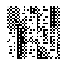

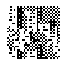

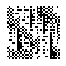

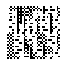

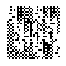

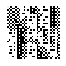

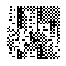

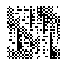

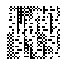

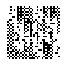

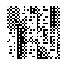

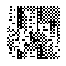

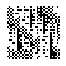

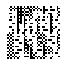

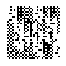

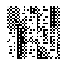

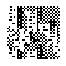

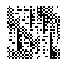

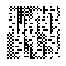

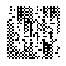

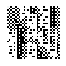

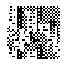

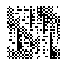

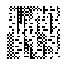

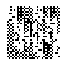

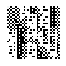

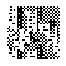

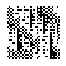

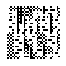

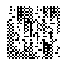

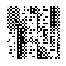

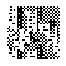

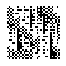

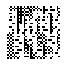

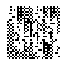

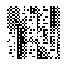

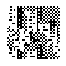

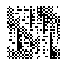

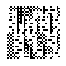

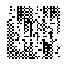

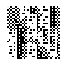

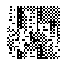

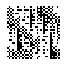

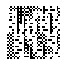

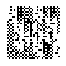

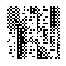

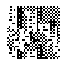

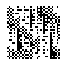

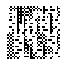

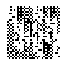

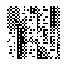

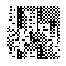

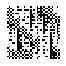

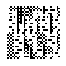

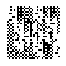

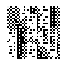

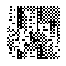

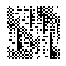

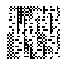

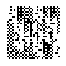

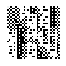

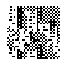

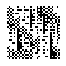

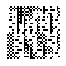

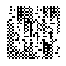

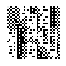

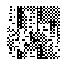

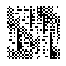

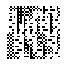

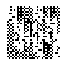

In [28]:
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")
for it in range(30000, 300000):
    X_mb = images[(it*10)%100:(it*10)%100+mb_size]
#     PC_ori = tf.reduce_mean(tf.concat([PC_ori, PC_ori_temp],0))
    
#     print((it*10)%100,(it*10)%100+mb_size)
    _, loss, recon_E, kl_E, PC_E2, PC_E3, PC_E4, PC_E5 = sess.run([solver, vae_loss, recon_loss, kl_loss, PC_loss2, PC_loss3, PC_loss4, PC_loss5], 
                                                    feed_dict={X: X_mb.reshape(mb_size, width, hight, num_channels_1),
                                                              z0: z[0].reshape(1,z_dim),
                                                              z1: z[1].reshape(1,z_dim),
                                                              z2: z[2].reshape(1,z_dim),
                                                              z3: z[3].reshape(1,z_dim),
                                                              z4: z[4].reshape(1,z_dim),
#                                                               z5: z[5].reshape(1,z_dim),
#                                                               z6: z[6].reshape(1,z_dim),
#                                                               z7: z[7].reshape(1,z_dim),
#                                                               z8: z[8].reshape(1,z_dim),
#                                                               z9: z[9].reshape(1,z_dim),
                                                              y: y_target,
                                                              y2:y_target2,
                                                              y3:y_target3,
                                                              y4:y_target4})

    if recon_E[0] <= 90:
        print('Optimization is done')
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
#         print('PC_E1:{}'.format(PC_E1))
        print('PC_E2:{}'.format(PC_E2))
        print('PC_E3:{}'.format(PC_E3))
        print('PC_E4:{}'.format(PC_E4))
        print('PC_E5:{}'.format(PC_E5))
        print()
        break
        
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {}'.format(loss))
        print('recon_E:{}'.format(recon_E))
        print('kl_E:{}'.format(kl_E))
#         print('PC_E1:{}'.format(PC_E1))
        print('PC_E2:{}'.format(PC_E2))
        print('PC_E3:{}'.format(PC_E3))
        print('PC_E4:{}'.format(PC_E4))
        print('PC_E5:{}'.format(PC_E5))       
        print()

        samples0 = sess.run(X_samples, feed_dict={zz: z[0].reshape(1,z_dim)})
        samples1 = sess.run(X_samples, feed_dict={zz: z[1].reshape(1,z_dim)})
        samples2 = sess.run(X_samples, feed_dict={zz: z[2].reshape(1,z_dim)})
        samples3 = sess.run(X_samples, feed_dict={zz: z[3].reshape(1,z_dim)})
        samples4 = sess.run(X_samples, feed_dict={zz: z[4].reshape(1,z_dim)})
#         samples5 = sess.run(X_samples, feed_dict={zz: z[5].reshape(1,z_dim)})
#         samples6 = sess.run(X_samples, feed_dict={zz: z[6].reshape(1,z_dim)})
#         samples7 = sess.run(X_samples, feed_dict={zz: z[7].reshape(1,z_dim)})
#         samples8 = sess.run(X_samples, feed_dict={zz: z[8].reshape(1,z_dim)})
#         samples9 = sess.run(X_samples, feed_dict={zz: z[9].reshape(1,z_dim)})
        

        fig0 = plot(samples0)
        k=0
        plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
        fig1 = plot(samples1)
        k=k+1
        plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
        fig2 = plot(samples2)
        k=k+1
        plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
        fig3 = plot(samples3)
        k=k+1
        plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
        fig4 = plot(samples4)
        k=k+1
        plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
#         fig5 = plot(samples5)
#         k=k+1
#         plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
#         fig6 = plot(samples6)
#         k=k+1
#         plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
#         fig7 = plot(samples7)
#         k=k+1
#         plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
#         fig8 = plot(samples8)
#         k=k+1
#         plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
#         fig9 = plot(samples9)
#         k=k+1
#         plt.savefig('out/{}-{}.png'.format(str(i).zfill(3),str(k).zfill(3)), bbox_inches='tight')
        i += 1
#         plt.close(fig)
save_path = saver.save(sess, "/tmp/model.ckpt")

In [1]:
import tensorflow as tf
saver = tf.train.Saver()
saver.restore(sess, "/tmp/model.ckpt")
# save_path = saver.save(sess, "/tmp/model.ckpt")

ValueError: No variables to save

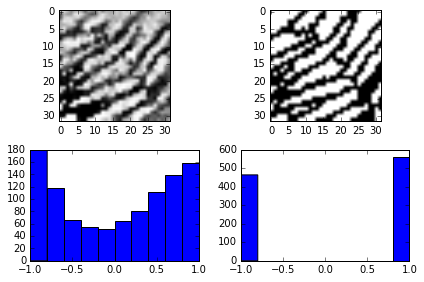

In [4]:
z_temp=sess.run(z_mu, feed_dict={X:X_mb.reshape(mb_size, width, hight, num_channels_1)})
%matplotlib inline
sample_temp=sess.run(X_samples, feed_dict={zz: z_temp[0:1]})
# plot_new(sample_temp)
fig = plt.figure()

ax1 = fig.add_subplot(221)
ax1.imshow(sample_temp.reshape(32,32),'gray')

ax2 = fig.add_subplot(222)
ax2.imshow(X_mb.reshape(32,32),'gray')

ax3 = fig.add_subplot(223)
ax3.hist(sample_temp.reshape(-1))

ax4 = fig.add_subplot(224)
ax4.hist(X_mb.reshape(-1))


plt.tight_layout()
fig = plt.gcf()

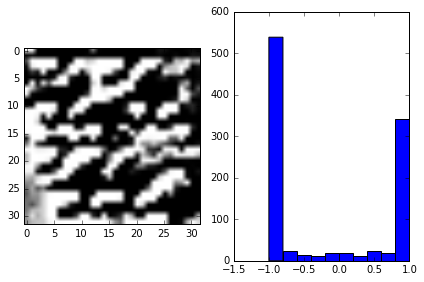

In [28]:
samples = sess.run(X_samples, feed_dict={zz: np.random.randn(mb_size, z_dim)})
fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow(samples.reshape(32,32),'gray')

ax2 = fig.add_subplot(122)
ax2.hist(samples.reshape(-1))
plt.tight_layout()

('VF_pred=', array([ 539.89651713,  518.22612832,  536.05412507,  541.03945318,
        547.11483264,  583.3070172 ,  642.03916973,  536.4571538 ,
        540.35431214,  579.66666186]))


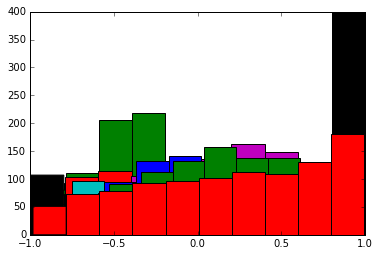

In [23]:
VF_pred = []
for i in range(10):
    samples=sess.run(X_samples, feed_dict={zz: z[i].reshape(1,z_dim)})
    VF_pred = np.append(VF_pred, correlation_fun_test(x=samples.reshape(32,32),input_dim=32,Rad=16))
    plt.hist(samples.reshape(-1))
print('VF_pred=',VF_pred)

In [98]:
VF = []
for i in range(0,100,10):
    VF = np.append(VF, correlation_fun_test(x=images[i].reshape(32,32),input_dim=32,Rad=0))
print('VF=',VF)

('VF=', array([ 1024.,  1024.,  1024.,  1024.,  1024.,  1024.,  1024.,  1024.,
        1024.,  1024.]))


In [62]:
print np.ceil(VF_pred)
print VF
PC_loss2=tf.reduce_mean(tf.square(y-PC_ran))

[ 540.  519.  537.  542.  548.  584.  643.  537.  541.  580.]
[ 648.  538.  566.  528.  588.  570.  564.  522.  524.  520.]


In [67]:
print np.mean(VF)
print np.mean(VF_pred)

556.8
556.415537106


In [29]:
S2 = np.zeros([5,17])
for i in range(5):
    samples=sess.run(X_samples, feed_dict={zz: z[i].reshape(1,z_dim)})
    for j in range(17):
        S2[i,j] = correlation_fun_test(x=samples.reshape(32,32),input_dim=32,Rad=j)
#     plt.hist(samples.reshape(-1))

S2_ori = np.zeros([10,17])
for i in range(10):
    for j in range(17):
        S2_ori[i,j] = correlation_fun_test(x=images[i*10].reshape(32,32),input_dim=32,Rad=j)

In [42]:
S2 = np.zeros([10,17])
for i in range(10):
    samples=sess.run(X_samples, feed_dict={zz:  np.random.randn(mb_size, z_dim)})
    for j in range(17):
        S2[i,j] = correlation_fun_test(x=samples.reshape(32,32),input_dim=32,Rad=j)
#     plt.hist(samples.reshape(-1))

S2_ori = np.zeros([10,17])
for i in range(10):
    for j in range(17):
        S2_ori[i,j] = correlation_fun_test(x=images[i*10].reshape(32,32),input_dim=32,Rad=j)

In [6]:
VF = []
for i in range(0,100,10):
#     print i
    VF = np.append(VF, correlation_fun_test(x=images[i].reshape(32,32),input_dim=32,Rad=16))
print('VF=',VF)
print S2_ori[:,-1]

('VF=', array([ 648.,  538.,  566.,  528.,  588.,  570.,  564.,  522.,  524.,  520.]))
[ 648.  538.  566.  528.  588.  570.  564.  522.  524.  520.]


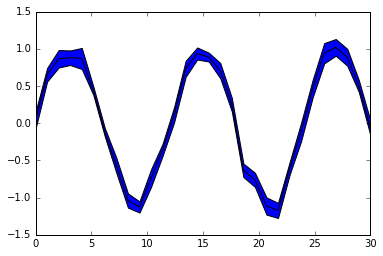

In [32]:
from matplotlib import pyplot as pl
import numpy as np

x = np.linspace(0, 15, 16)
y = np.sin(x/6*np.pi)
error = np.random.normal(0.1, 0.02, size=y.shape)
y += np.random.normal(0, 0.1, size=y.shape)

pl.plot(x, y, 'k-')
pl.fill_between(x, y-error, y+error)
pl.show()

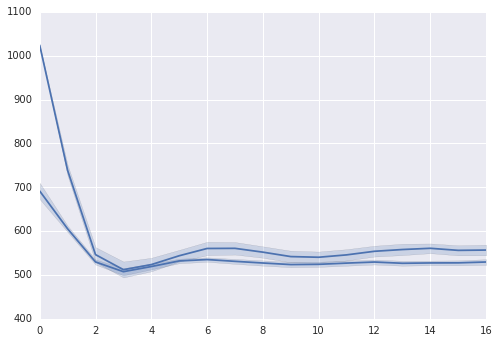

In [43]:
import seaborn as sns
x = np.linspace(0, 16, 17)
sns.tsplot(data=S2)
sns.tsplot(data=S2_ori)

In [22]:
weight1 = sess.run(deconv1_weight)
weight2 = sess.run(deconv2_weight)
weight3 = sess.run(deconv3_weight)

In [25]:
import scipy.io as sio
sio.savemat('weight1.mat',mdict={'weight1':weight1})
sio.savemat('weight2.mat',mdict={'weight2':weight2})
sio.savemat('weight3.mat',mdict={'weight3':weight3})

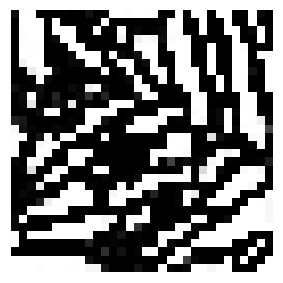

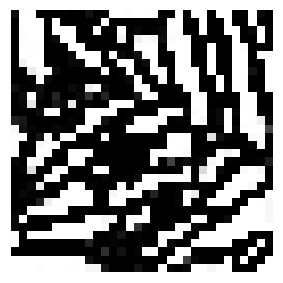

In [10]:
def plot(samples):
    fig = plt.figure(figsize=(20, 20))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(32, 32), cmap='Greys_r')

    return fig


plot(sample_temp)